In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from google.colab.data_table import DataTable
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.colors
import tensorflow as tf
import statsmodels.api as sm

DataTable.max_columns = 100

#import data, remove unnecessary 'index' column
df = pd.read_csv("credit_data.txt")
df = df.drop('index', 1)
num_columns = ['A2','A5', 'A8', 'A11', 'A13', 'A16', 'A18']; #numerical features
cat_columns = ['A1', 'A3', 'A4', 'A6', 'A7', 'A9', 'A10', 'A12', 'A14', 'A15', 'A17', 'A19', 'A20']; #categorical features

#find the frequency of each option for each categorical feature
df_cat = df.apply(lambda x: x.value_counts() if x.name in cat_columns else x).T.stack()
df_cat[cat_columns]

#find the distribution of each numerical feature
df[num_columns].describe()

#Change label to (1=good, 0=bad)
df['Label'] = -1*(df['Label']-2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
#One-Hot Encoding for categorical variables
data = pd.get_dummies(df, columns = cat_columns)
data.insert(len(data.columns)-1, 'Label', data.pop('Label')) #move Label to the end

#normalized data frame
data_n = data.copy()
data_n[num_columns] = MinMaxScaler().fit_transform(data_n[num_columns])

col_names = np.array(data_n.drop(labels='Label', axis=1).columns)
n_classes = data_n.shape[1]

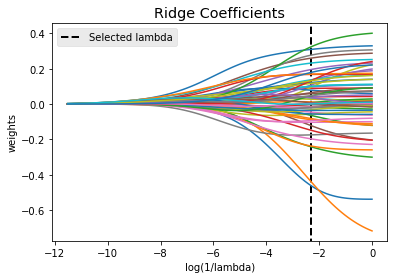

In [ ]:
### Ridge Regression
## Visual of Coefficients
#train/test split
X = data_n.drop(['Label'], axis=1)
y = data_n['Label']
myseed = 314
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=myseed, test_size=.2)

alphas = np.logspace(start=0,stop=5,num=101)
coefs = []

for a in alphas:
    rcv = RidgeClassifierCV(alphas=[a], cv=10, fit_intercept=False)
    rcv.fit(Xtrain, ytrain)
    coefs.append(np.ravel(rcv.coef_))

ax = plt.gca()
ax.plot(np.log(1/alphas), coefs)
plt.style.use("ggplot")
plt.xlabel("log(1/lambda)")
plt.ylabel("weights")
plt.title("Ridge Coefficients")
plt.axis("tight")
ax.vlines(x=[np.log(1/10)], ymin = -0.8, ymax = 0.5, colors='black', ls='--', lw=2, label='Selected lambda')
legend = plt.legend(loc="upper left")
plt.setp(legend.get_texts(), color='k')
plt.show()

Ridge Cross-Validated alpha value: 10.0
ROC:  0.7512141816415735


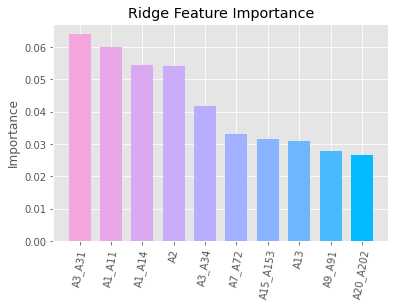

In [ ]:
## CV for actual model
rcv = RidgeClassifierCV(cv=10)
rcv.fit(Xtrain,ytrain)
alpha_rcv = rcv.alpha_
print("Ridge Cross-Validated alpha value:", alpha_rcv)

#use the best hyperparameter on the test set
rc = RidgeClassifier(alpha=[alpha_rcv])
rc.fit(Xtest,ytest)
yhatr_ridge = rc.predict(Xtest)
print("ROC: ", roc_auc_score(ytest,yhatr_ridge))

#obtain significance coefficients
rcoef_n = sum(abs(rc.coef_)) #turn to 1D array
rcoef_n = abs(rcoef_n)/sum(abs(rcoef_n)) #scaled as a percentage
rcoef_n = np.vstack((rcoef_n, col_names)) #combined with corresponding feature
rcoef_n = rcoef_n[:, rcoef_n[0, :].argsort()[::-1]] #sorted by importance

colors = ['#f4a6df', '#e8a7e8', '#daa9f1', '#caacf9', '#b7aeff', '#a2b1ff', '#8ab4ff', 
          '#6eb7ff', '#4bb9ff', '#04bbff']

plt.figure()
plt.bar(rcoef_n[1, 0:10], rcoef_n[0, 0:10], color = colors, width = 0.7)
plt.xticks(rotation=80)
plt.ylabel('Importance');
plt.title('Ridge Feature Importance');

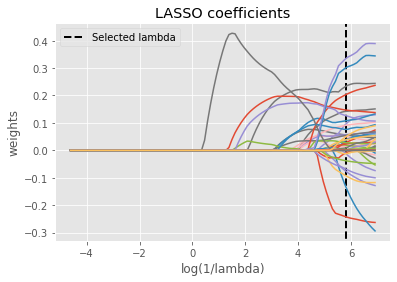

In [ ]:
### LASSO
## Visual of Coefficients
#train/test split
alphas = np.logspace(start=-3,stop=2,num=101)
coefs = []

for a in alphas:
    lcv = LassoCV(alphas=[a], cv=10, fit_intercept=False)
    lcv.fit(Xtrain, ytrain)
    coefs.append(np.ravel(lcv.coef_))

ax = plt.gca()
ax.plot(np.log(1/alphas), coefs)
plt.xlabel("log(1/lambda)")
plt.ylabel("weights")
plt.title("LASSO coefficients")
plt.axis("tight")
ax.vlines(x=[np.log(1/0.0029488333489478087)], ymin = -0.4, ymax = 0.5, colors='black', ls='--', lw=2, label='Selected lambda')
legend = plt.legend(loc="upper left")
plt.setp(legend.get_texts(), color='k')
plt.show()

LASSO Cross-Validated alpha value:  0.0029488333489478087
Best cutoff for prediction:  0.6500000000000004
ROC:  0.8688683827100534


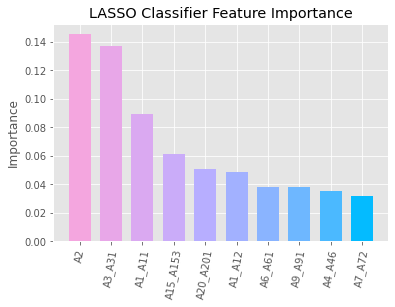

In [ ]:
## CV for actual LASSO model
lcv = LassoCV(cv=10)
lcv.fit(Xtrain,ytrain)
alpha_lcv = lcv.alpha_
mse_lcv = lcv.mse_path_
print("LASSO Cross-Validated alpha value: ", alpha_lcv)

#use the best hyperparameter on the test set
lc = Lasso(alpha=[alpha_lcv])
lc.fit(Xtest,ytest)
yhatr_lasso = lc.predict(Xtest)

#this gives us rational predictions,
#we need to find the best cutoff for predicting 0 or 1
yhatr_1 = [0] * len(yhatr_lasso)
yhatr_1_best = [0] * len(yhatr_lasso)
best_roc = 0
best_cutoff = 0

for a in np.arange(0.2, 1.0, 0.01):
  for i in range(len(yhatr_lasso)):
    if (yhatr_lasso[i] > a):
      yhatr_1[i] = 1
    else:
      yhatr_1[i] = 0
  current_roc = roc_auc_score(ytest,yhatr_1)
  if current_roc > best_roc:
    best_roc = current_roc
    best_cutoff = a
    yhatr_1_best = yhatr_1.copy()

print("Best cutoff for prediction: ", best_cutoff)
print("ROC: ", best_roc)

#obtain significance coefficients
lcoef_n = abs(lc.coef_)/sum(abs(lc.coef_)) #scaled as a percentage
lcoef_n = np.vstack((lcoef_n, col_names)) #combined with corresponding feature
lcoef_n = lcoef_n[:, lcoef_n[0, :].argsort()[::-1]] #sorted by importance

colors = ['#f4a6df', '#e8a7e8', '#daa9f1', '#caacf9', '#b7aeff', '#a2b1ff', '#8ab4ff', 
          '#6eb7ff', '#4bb9ff', '#04bbff']
          
plt.bar(lcoef_n[1, 0:10], lcoef_n[0, 0:10], color = colors, width = 0.7)
plt.xticks(rotation=80)
plt.ylabel('Importance');
plt.title('LASSO Classifier Feature Importance');

ROC for NN1:  0.6246964545896065
ROC for NN2:  0.7187955318115591


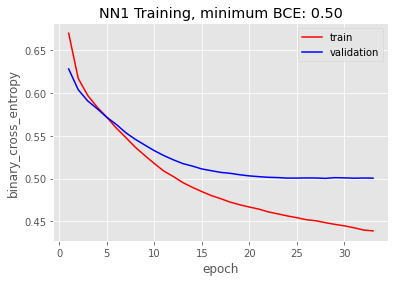

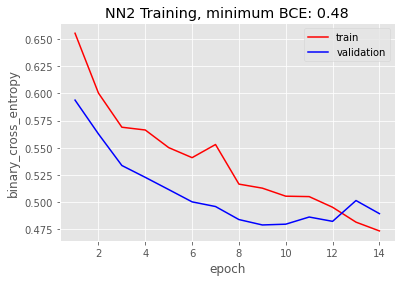

In [ ]:
### Neural Nets with Keras
## Neural Net 1: Single Layer, AdaptSive Early Stopping
nunits = 20
ytrain_OHE = pd.get_dummies(ytrain)
ytest_OHE = pd.get_dummies(ytest)
nx = Xtrain.shape[1]
nn1 = tf.keras.models.Sequential()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# add one hidden layer, one binary probability output
nn1.add(tf.keras.layers.Dense(units=nunits,activation='relu',input_shape=(nx,)))
nn1.add(tf.keras.layers.Dense(units=2,activation='softmax'))

#compile model
nn1.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

nepoch = 100
nhist = nn1.fit(Xtrain,ytrain_OHE,verbose=0,epochs=nepoch,batch_size=50,validation_data=(Xtest,ytest_OHE),callbacks=early_stopping)

# plot training by epoch
yhatnn = nn1.predict(Xtrain)
yprednn = nn1.predict(Xtest)

trL = np.array((nhist.history['loss']))
teL = np.array((nhist.history['val_loss']))
epind = range(1,len(trL)+1)

plt.figure()
plt.plot(epind,trL,c='red',label='train')
plt.plot(epind,teL,c='blue',label='validation')
plt.xlabel('epoch'); plt.ylabel('binary_cross_entropy')
plt.legend()
minbce = teL.min()
plt.title(f'NN1 Training, minimum BCE: {minbce:0.2f}')

nn1_pred = nn1.predict(Xtest) 
yhatr_nn1 = np.argmax(nn1_pred,axis=1)
print("ROC for NN1: ", roc_auc_score(ytest,yhatr_nn1))

## Neural Net 2: Two-Layers, Dropout = 0.4, Adaptive Early Stopping
nunits = 50
nn2 = tf.keras.models.Sequential()

# add two hidden layers with dropout, one binary probability output
nn2.add(tf.keras.layers.Dense(units=nunits,activation='relu',input_shape=(nx,)))
nn2.add(tf.keras.layers.Dropout(.2))
nn2.add(tf.keras.layers.Dense(units=nunits,activation='relu',input_shape=(nx,)))
nn2.add(tf.keras.layers.Dropout(.2))
nn2.add(tf.keras.layers.Dense(units=nunits,activation='relu',input_shape=(nx,)))
nn2.add(tf.keras.layers.Dropout(.2))
nn2.add(tf.keras.layers.Dense(units=nunits,activation='relu',input_shape=(nx,)))
nn2.add(tf.keras.layers.Dropout(.2))
nn2.add(tf.keras.layers.Dense(units=nunits,activation='relu',input_shape=(nx,)))
nn2.add(tf.keras.layers.Dropout(.2))
nn2.add(tf.keras.layers.Dense(units=2,activation='softmax'))

#compile model
nn2.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

nhist2 = nn2.fit(Xtrain,ytrain_OHE,verbose=0,epochs=nepoch,batch_size=50,validation_data=(Xtest,ytest_OHE),callbacks=early_stopping)

### plot training by epoch
yhatnn2 = nn2.predict(Xtrain)
yprednn2 = nn2.predict(Xtest)

trL2 = np.array((nhist2.history['loss']))
teL2 = np.array((nhist2.history['val_loss']))
epind2 = range(1,len(trL2)+1)

plt.figure()
plt.plot(epind2,trL2,c='red',label='train')
plt.plot(epind2,teL2,c='blue',label='validation')
plt.xlabel('epoch'); plt.ylabel('binary_cross_entropy')
plt.legend()
minbce2 = teL2.min()
plt.title(f'NN2 Training, minimum BCE: {minbce2:0.2f}')

nn2_pred = nn2.predict(Xtest) 
yhatr_nn2 = np.argmax(nn2_pred,axis=1)
print("ROC for NN2: ", roc_auc_score(ytest,yhatr_nn2))

In [ ]:
### Logit
XX = sm.add_constant(Xtrain)
lfitM = sm.Logit(ytrain, XX).fit()
XXp = sm.add_constant(Xtest)
phlgt = lfitM.predict(XXp)

         Current function value: 0.444838
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


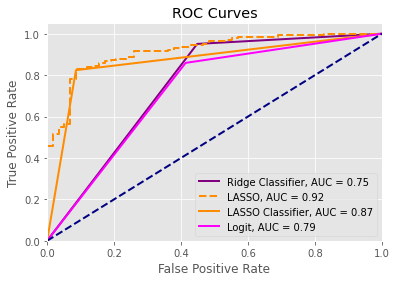

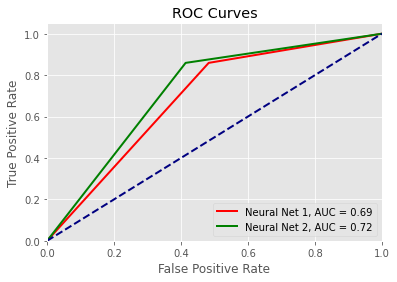

In [ ]:
#obtain roc_auc for each model
fpr_ridge, tpr_ridge, _ = roc_curve(ytest, yhatr_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)
fpr_lasso, tpr_lasso, _ = roc_curve(ytest, yhatr_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)
fpr_lasso_c, tpr_lasso_c, _ = roc_curve(ytest, yhatr_1_best)
roc_auc_lasso_c = auc(fpr_lasso_c, tpr_lasso_c)
fpr_nn1, tpr_nn1, _ = roc_curve(ytest, yhatr_nn1)
roc_auc_nn1 = auc(fpr_nn1, tpr_nn1)
fpr_nn2, tpr_nn2, _ = roc_curve(ytest, yhatr_nn2)
roc_auc_nn2 = auc(fpr_nn2, tpr_nn2)
fpr_log, tpr_log, _ = roc_curve(ytest, phlgt)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure()
lw = 2
plt.plot(fpr_ridge,tpr_ridge,color="purple",lw=lw,
         label="Ridge Classifier, AUC = %0.2f" % roc_auc_ridge,)
plt.plot(fpr_lasso,tpr_lasso,color="darkorange",lw=lw,
         label="LASSO, AUC = %0.2f" % roc_auc_lasso, linestyle="--",)
plt.plot(fpr_lasso_c,tpr_lasso_c,color="darkorange",lw=lw,
         label="LASSO Classifier, AUC = %0.2f" % roc_auc_lasso_c,)
plt.plot(fpr_nn2,tpr_nn2,color="magenta",lw=lw,
         label="Logit, AUC = %0.2f" % roc_auc_log,)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
legend = plt.legend(loc="lower right")
plt.setp(legend.get_texts(), color='k')
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_nn1,tpr_nn1,color="red",lw=lw,
         label="Neural Net 1, AUC = %0.2f" % roc_auc_nn1,)
plt.plot(fpr_nn2,tpr_nn2,color="green",lw=lw,
         label="Neural Net 2, AUC = %0.2f" % roc_auc_nn2,)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
legend = plt.legend(loc="lower right")
plt.setp(legend.get_texts(), color='k')
plt.show()